In [ ]:
import spike.spike_analysis.spike_collection as sc
import spike.spike_analysis.spike_recording as sr
import spike.spike_analysis.firing_rate_calculations as fr
import spike.spike_analysis.normalization as norm
import spike.spike_analysis.single_cell as single_cell
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import behavior.boris_extraction as boris
import matplotlib.pyplot as plt
import pickle


In [ ]:
# Define paths to the pkl files
cagemate_path = r'/Users/thomasheeps/code/researchRepos/diff_fam_social_memory_ephys/other_peoples_sutff/Thomas/cagemate_spike_collection.pkl'
novel_path = r'/Users/thomasheeps/code/researchRepos/diff_fam_social_memory_ephys/other_peoples_sutff/Thomas/novel_spike_collection.pkl'

# Load the cagemate spike collection
with open(cagemate_path, 'rb') as f:
    cagemate_spike_collection = pickle.load(f)

# Load the novel spike collection
with open(novel_path, 'rb') as f:
    novel_spike_collection = pickle.load(f)

print(f"Loaded {len(cagemate_spike_collection)} cagemate recordings.")
print(f"Loaded {len(novel_spike_collection)} novel recordings.")

if cagemate_spike_collection:
    print(f"Cagemate Units (First Recording): {cagemate_spike_collection[0].get_unit_ids()}")
if novel_spike_collection:
    print(f"Novel Units (First Recording): {novel_spike_collection[0].get_unit_ids()}")


Loaded 12 cagemate recordings.
Loaded 9 novel recordings.
Cagemate Units (First Recording): [2 3 4 5 6 7]
Novel Units (First Recording): [2 4 1]


In [ ]:
import pandas as pd
import glob
import os

folder_path = r"/Users/thomasheeps/code/researchRepos/diff_fam_social_memory_ephys/other_peoples_sutff/Thomas/habit_dishabit_aggregated"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    df['condition'] = 'cagemate' if '_cage_' in file else 'novel'
    df['subject_id'] = os.path.basename(file).split('_')[0]
    dataframes.append(df)

# Combine all data into a single DataFrame
full_df = pd.concat(dataframes, ignore_index=True)

print(full_df.head(5))


  Observation id     Observation date  Description  \
0      22_nov_p1  2024-10-07 16:14:23          NaN   
1      22_nov_p1  2024-10-07 16:14:23          NaN   
2      22_nov_p1  2024-10-07 16:14:23          NaN   
3      22_nov_p1  2024-10-07 16:14:23          NaN   
4      22_nov_p1  2024-10-07 16:14:23          NaN   

                                          Media file  Total length   FPS  \
0  /Users/naylajimenez/Downloads/22_nov_p1_conver...        2342.2  15.0   
1  /Users/naylajimenez/Downloads/22_nov_p1_conver...        2342.2  15.0   
2  /Users/naylajimenez/Downloads/22_nov_p1_conver...        2342.2  15.0   
3  /Users/naylajimenez/Downloads/22_nov_p1_conver...        2342.2  15.0   
4  /Users/naylajimenez/Downloads/22_nov_p1_conver...        2342.2  15.0   

        Subject             Behavior Behavioral category  Modifiers  ...  \
0  social_agent         mice back in                 NaN        NaN  ...   
1  social_agent      facial sniffing                 NaN        Na

In [16]:
# Filter to keep only behavioral event rows
behavior_df = full_df[full_df['Behavior'].notna()].copy()

# converting Coding duration to numeric
behavior_df['Coding duration'] = pd.to_numeric(behavior_df['Coding duration'], errors='coerce')

# Filter only facial sniffing and anogenital sniffing
behaviors_of_interest = ['facial sniffing', 'anogenital sniffing']
filtered_df = behavior_df[behavior_df['Behavior'].isin(behaviors_of_interest)]

# Calculate total investigation time by cagemate and novel
investigation_time = filtered_df.groupby('condition')['Coding duration'].sum()
print("Total Investigation Time:\n", investigation_time)

# Calculate number of events by cagemate and novel
event_counts = filtered_df.groupby('condition').size()
print("\nNumber of Events:\n", event_counts)

# Average event length
average_event_length = filtered_df.groupby('condition')['Coding duration'].mean()
print("\nAverage Event Length:\n", average_event_length)


Total Investigation Time:
 condition
cagemate    1254335.245
novel       1812698.591
Name: Coding duration, dtype: float64

Number of Events:
 condition
cagemate    1587
novel       1848
dtype: int64

Average Event Length:
 condition
cagemate    1732.507244
novel       1490.706078
Name: Coding duration, dtype: float64


In [ ]:
import behavior.boris_extraction as boris

# Get significant facial sniffing bouts for subject "subject"
filtered_bouts = boris.get_behavior_bouts(
    boris_df=behavior_df,
    subject=['subject'],
    behavior=['facial sniffing'],
    min_iti=1.0,    # Combine bouts separated by less than 1 second
    min_bout=2.0    # Only keep bouts at least 2 seconds long
)

print(filtered_bouts)  # start and stop times in milliseconds


[[ 346214.  351821.]
 [ 383185.  385407.]
 [ 410259.  412500.]
 [ 413536.  416704.]
 [ 548286.  550929.]
 [ 583185.  587571.]
 [ 593111.  595438.]
 [ 605067.  615067.]
 [ 622600.  625200.]
 [ 626867.  632553.]
 [ 633733.  636867.]
 [ 637933.  643400.]
 [ 648733.  656133.]
 [ 659067.  668867.]
 [ 671148.  673875.]
 [ 678600.  683125.]
 [ 688133.  691266.]
 [ 692875.  695312.]
 [ 701533.  704188.]
 [ 705267.  708750.]
 [ 714667.  728467.]
 [ 734600.  737666.]
 [ 740000.  748933.]
 [ 750067.  752667.]
 [ 753667.  762000.]
 [ 765000.  772741.]
 [ 776036.  784000.]
 [ 789067.  797733.]
 [ 803533.  806932.]
 [ 808533.  817199.]
 [ 821148.  832200.]
 [ 834533.  846000.]
 [ 847400.  851267.]
 [ 852733.  855000.]
 [ 861000.  875333.]
 [ 878067.  881732.]
 [ 887200.  896200.]
 [ 897733.  901133.]
 [ 903964.  908562.]
 [ 933036.  936071.]
 [ 949750.  955500.]
 [ 964000.  971267.]
 [ 974733.  991200.]
 [ 995067. 1000750.]
 [1002333. 1006267.]
 [1010267. 1019400.]
 [1034667. 1037533.]
 [1045933. 10

In [ ]:
# Example using your thresholded bouts (assuming you already ran get_behavior_bouts):

# Get bouts for each condition (adjust subject list if needed)
cagemate_bouts = boris.get_behavior_bouts(
    boris_df=behavior_df,
    subject=['subject'],
    behavior=['facial sniffing', 'anogenital sniffing'],
    min_iti=1.0,
    min_bout=2.0
)

novel_bouts = boris.get_behavior_bouts(
    boris_df=behavior_df,
    subject=['social_agent'],
    behavior=['facial sniffing', 'anogenital sniffing'],
    min_iti=1.0,
    min_bout=2.0
)

# Calculate total significant investigation time with ms to s
cagemate_total_time = (cagemate_bouts[:, 1] - cagemate_bouts[:, 0]).sum() / 1000
novel_total_time = (novel_bouts[:, 1] - novel_bouts[:, 0]).sum() / 1000

# difference
difference = novel_total_time - cagemate_total_time

print(f"Cagemate Total Investigation Time: {cagemate_total_time:.2f} s")
print(f"Novel Total Investigation Time: {novel_total_time:.2f} s")
print(f"Difference (Novel - Cagemate): {difference:.2f} s")


Cagemate Total Investigation Time: 1197.95 s
Novel Total Investigation Time: 921.12 s
Difference (Novel - Cagemate): -276.83 s


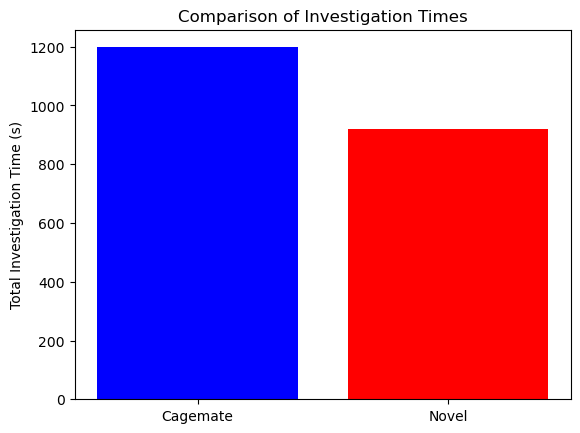

In [ ]:
import matplotlib.pyplot as plt

conditions = ['Cagemate', 'Novel']
times = [cagemate_total_time, novel_total_time]

plt.bar(conditions, times, color=['blue', 'red'])
plt.ylabel('Total Investigation Time (s)')
plt.title('Comparison of Investigation Times')
plt.show()
